In [1]:
from PIL import Image
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage import transform
from skimage.draw import polygon
import math

# 1. Загрузка или создание изображения

In [2]:
def user_image():
    try:
        img = Image.open('image1.jpg')
        image = np.array(img, dtype=np.uint8)
        return image
    except FileNotFoundError:
        print("Файл 'image1.jpg' не найден!")
        return None
    
def create_test_image_red_square():
    """Создает тестовое изображение с красным квадратом в центре."""
    image = np.zeros((200, 200, 3), dtype=np.uint8)
    image[50:150, 50:150] = [255, 0, 0]  # Красный квадрат
    return image


def create_test_image_document():
    """Создает тестовое изображение, имитирующее документ (зеленый четырехугольник)."""
    image = np.zeros((400, 400, 3), dtype=np.uint8)
    pts = np.array([[50, 50], [350, 50], [380, 380], [20, 380]], dtype=float)
    rr, cc = polygon(pts[:, 1], pts[:, 0])  # polygon принимает (r, c)
    rr = np.clip(rr, 0, image.shape[0] - 1)
    cc = np.clip(cc, 0, image.shape[1] - 1)
    image[rr, cc] = [0, 255, 0]
    return image

In [3]:
image=user_image()

In [4]:
red_square = create_test_image_red_square()

In [5]:
green_reactangle = create_test_image_document()

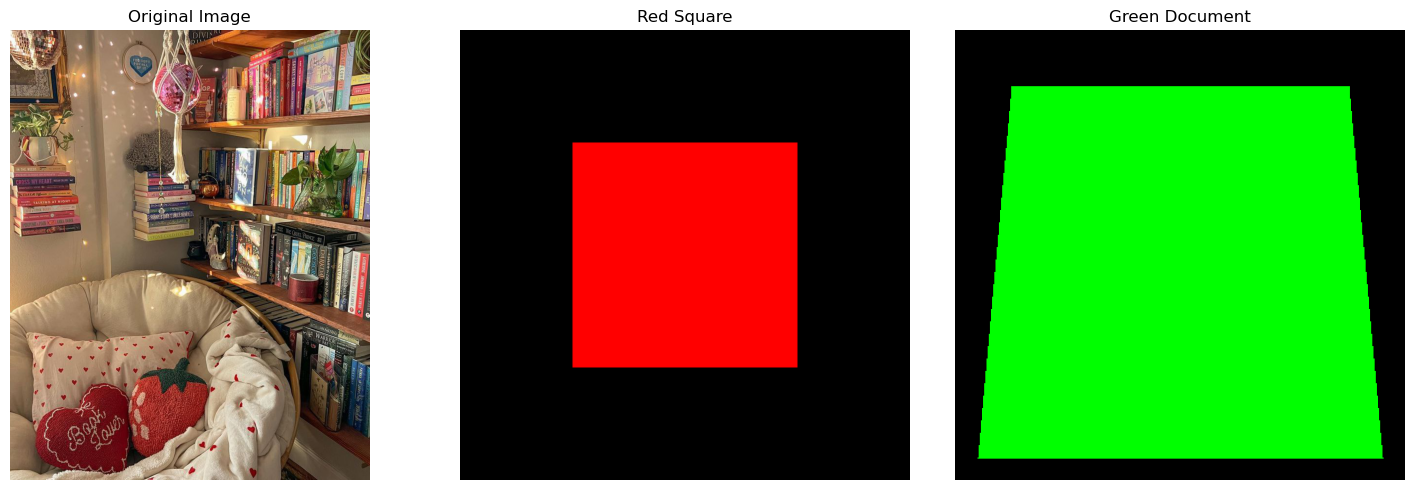

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

images = [
    user_image(),
    create_test_image_red_square(),
    create_test_image_document()
]

titles = ['Original Image', 'Red Square', 'Green Document']

for i, (ax, img, title) in enumerate(zip(axes, images, titles)):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Перенос (Translation)
это аффинное преобразование, необходимое для перемещение каждой точки изображения на заданное расстояние в направлении оси X и/или Y. 


In [7]:
def example_translation():
    """Пример 1: Перенос (сдвиг) изображения."""
    print("Выполняется пример 1: Перенос (Translation)...")
   
    # Сдвигаем на +50 пикселей вниз и +30 вправо.
    # В ndimage.affine_transform координаты входа вычисляются как:
    #   input_coords = A @ output_coords + offset
    # Для чистого сдвига A = I, а чтобы получить input(y-50, x-30),
    # offset должен быть (-50, -30).
    dy, dx = 50, 30
    offset = (-dy, -dx)
    A = np.eye(2)  # только по (y, x)

    translated = np.zeros_like(image)
    for ch in range(image.shape[2]):
        translated[..., ch] = ndimage.affine_transform(
            image[..., ch],
            A,
            offset=offset,
            order=1,           # билинейная интерполяция по каналам
            mode='constant',
            cval=0.0,
            prefilter=True
        ).astype(image.dtype)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original (Translation)')
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Translated (+50↓, +30→)')
    plt.imshow(translated)
    plt.axis('off')
    plt.show()

Выполняется пример 1: Перенос (Translation)...


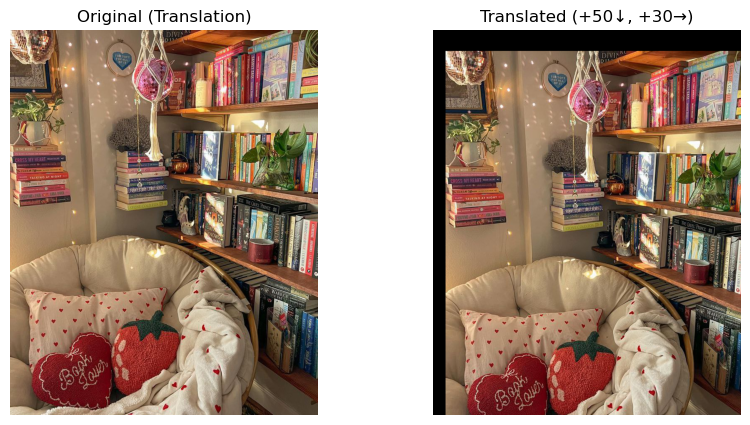

In [8]:
example_translation()

# Поворот изображения

Реализация поворота c испльзованием стандартных функций

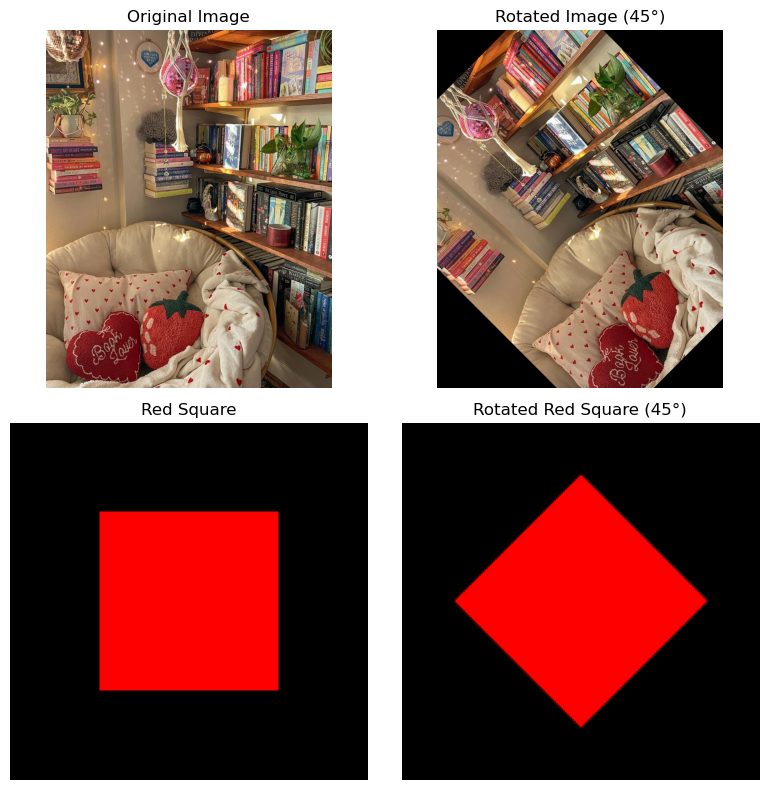

In [9]:
plt.figure(figsize=(8, 8))

# Первое изображение - оригинал
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Второе изображение - повернутое основное
plt.subplot(2, 2, 2)
rotated_image = ndimage.rotate(image, 45, reshape=False)
plt.imshow(rotated_image)
plt.title('Rotated Image (45°)')
plt.axis('off')

# Третье изображение - красный квадрат
plt.subplot(2, 2, 3)
plt.imshow(red_square)
plt.title('Red Square')
plt.axis('off')

# Четвертое изображение - повернутый красный квадрат
plt.subplot(2, 2, 4)
rotated_red_square = ndimage.rotate(red_square, 45, reshape=False)
plt.imshow(rotated_red_square)
plt.title('Rotated Red Square (45°)')
plt.axis('off')

# Улучшаем расположение и показываем
plt.tight_layout()
plt.show()


Ручная реализация поворота без стандартных функций

In [10]:
def example_manual_rotation():
    """Пример 3: Ручная реализация поворота без стандартных функций."""
    print("\nВыполняется пример 3: Ручная реализация поворота...")
    try:
        img = Image.open('image1.jpg').convert('RGB')
        src_image = np.array(img)
    except FileNotFoundError:
        print("Файл 'image.jpg' не найден. Создается тестовое изображение.")
        src_image = create_test_image_red_square()

    height, width, _ = src_image.shape
    center_x, center_y = width // 2, height // 2
    angle_deg = 45
    angle_rad = math.radians(angle_deg)
    dst_image = np.zeros_like(src_image)

    cos_a = math.cos(angle_rad)
    sin_a = math.sin(angle_rad)

    # Инверсное преобразование координат (nearest-neighbor)
    for y_new in range(height):
        y_shifted = y_new - center_y
        for x_new in range(width):
            x_shifted = x_new - center_x

            # Поворачиваем в обратную сторону для выборки источника
            x_orig =  x_shifted *  cos_a + y_shifted * sin_a
            y_orig = -x_shifted *  sin_a + y_shifted * cos_a

            x_orig += center_x
            y_orig += center_y

            x_i = int(round(x_orig))
            y_i = int(round(y_orig))

            if 0 <= x_i < width and 0 <= y_i < height:
                dst_image[y_new, x_new] = src_image[y_i, x_i]

    plt.figure()
    plt.imshow(dst_image)
    plt.title('Manual Rotation (45°, NN)')
    plt.axis('off')
    plt.show()


Выполняется пример 3: Ручная реализация поворота...


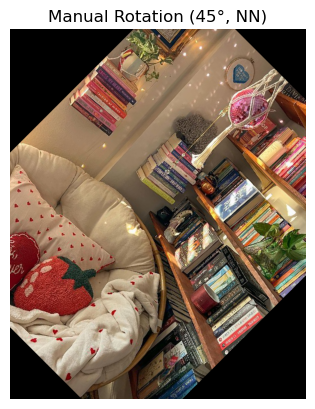

In [11]:
example_manual_rotation()

# Масштабирование и сравнение интерполяций


In [12]:
img = Image.open('image2.webp')
image = np.array(img)  # uint8 array (H, W, C)


In [13]:
width, height = img.size
new_dim = ( width * 4 , height * 4)
nearest = img.resize ( new_dim , resample = Image.Resampling.NEAREST )
linear = img.resize ( new_dim , resample = Image.Resampling.BILINEAR )
cubic = img.resize ( new_dim , resample = Image.Resampling.BICUBIC )

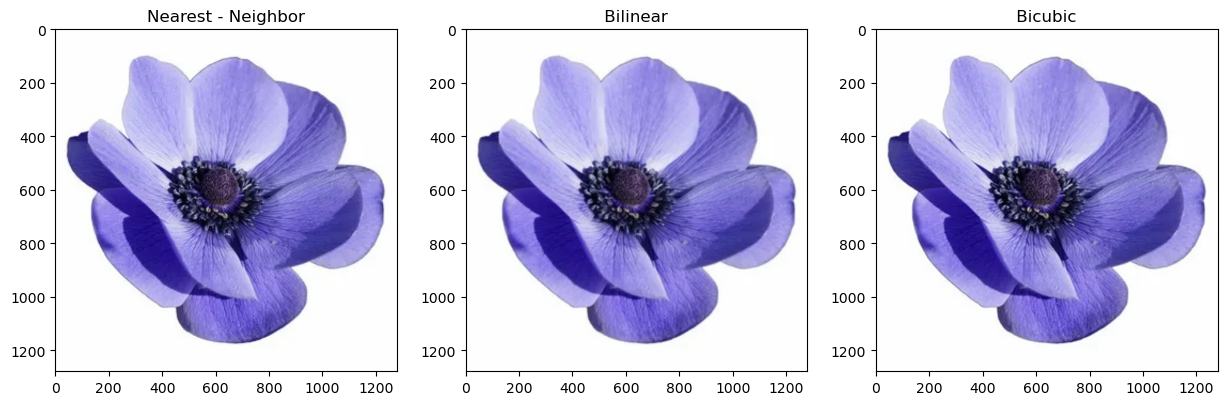

In [14]:
fig , axes = plt . subplots (1 , 3 , figsize =(15 , 5) )
axes [0]. imshow ( nearest )
axes [0]. set_title ( 'Nearest - Neighbor')
axes [1]. imshow ( linear )
axes [1]. set_title ( ' Bilinear ')
axes [2]. imshow ( cubic )
axes [2]. set_title ( ' Bicubic ')
plt . show ()

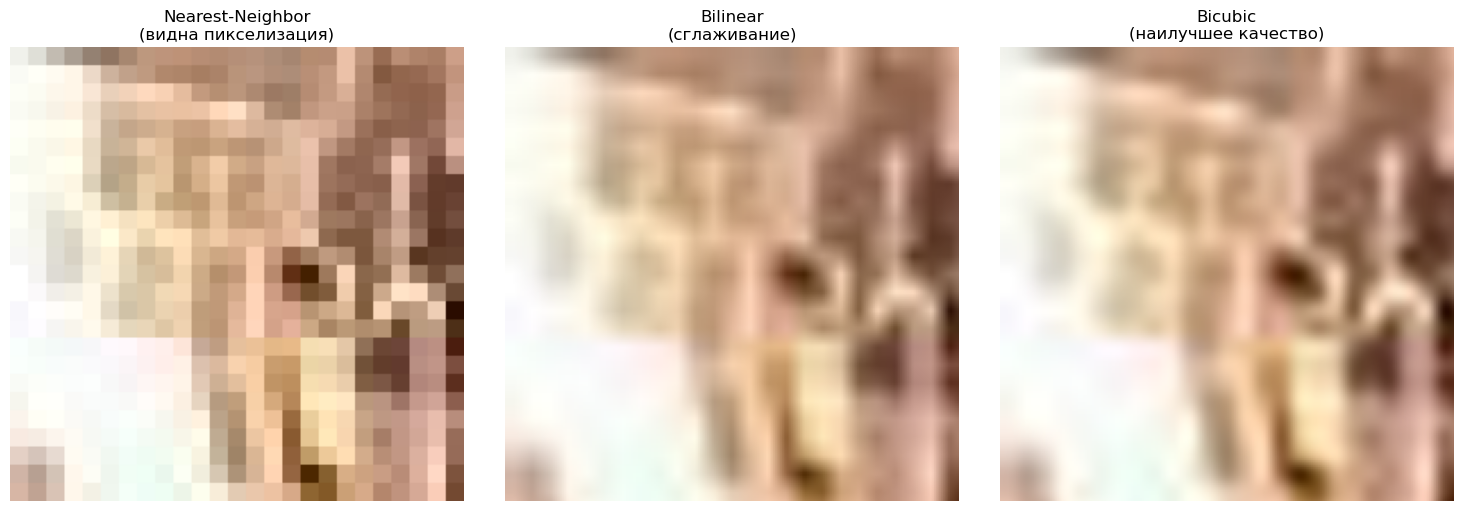

In [23]:
img = Image.open('image1.jpg')
width, height = img.size

# Увеличиваем в 8 раз и обрезаем маленький участок для детального сравнения
new_dim = (width * 8, height * 8)

nearest = img.resize(new_dim, resample=Image.Resampling.NEAREST)
linear = img.resize(new_dim, resample=Image.Resampling.BILINEAR)  
cubic = img.resize(new_dim, resample=Image.Resampling.BICUBIC)

# Берем маленький кусочек для детального сравнения (например, 200x200 пикселей)
crop_size = 200
nearest_crop = nearest.crop((0, 0, crop_size, crop_size))
linear_crop = linear.crop((0, 0, crop_size, crop_size))
cubic_crop = cubic.crop((0, 0, crop_size, crop_size))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(nearest_crop)
axes[0].set_title('Nearest-Neighbor\n(видна пикселизация)')
axes[0].axis('off')

axes[1].imshow(linear_crop)
axes[1].set_title('Bilinear\n(сглаживание)')
axes[1].axis('off')

axes[2].imshow(cubic_crop)
axes[2].set_title('Bicubic\n(наилучшее качество)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Комбинированное преобразование: Поворот и Масштаб

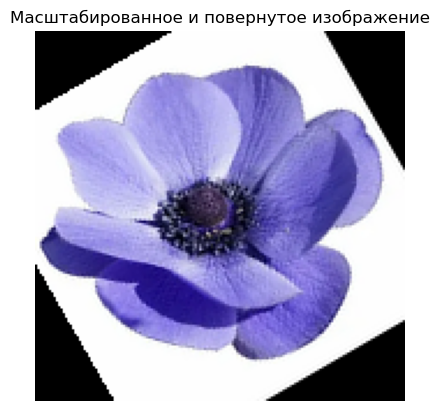

In [15]:
# Масштабирование изображения до 50% от исходного размера
scaled_image = ndimage.zoom(image, (0.5, 0.5, 1))

# Поворот изображения на 30 градусов
final_image = ndimage.rotate(scaled_image, 30, reshape=False)

# Отображение результата
plt.imshow(final_image)
plt.title('Масштабированное и повернутое изображение')
plt.axis('off')  # Скрываем оси
plt.show()

# Перспективное преобразование

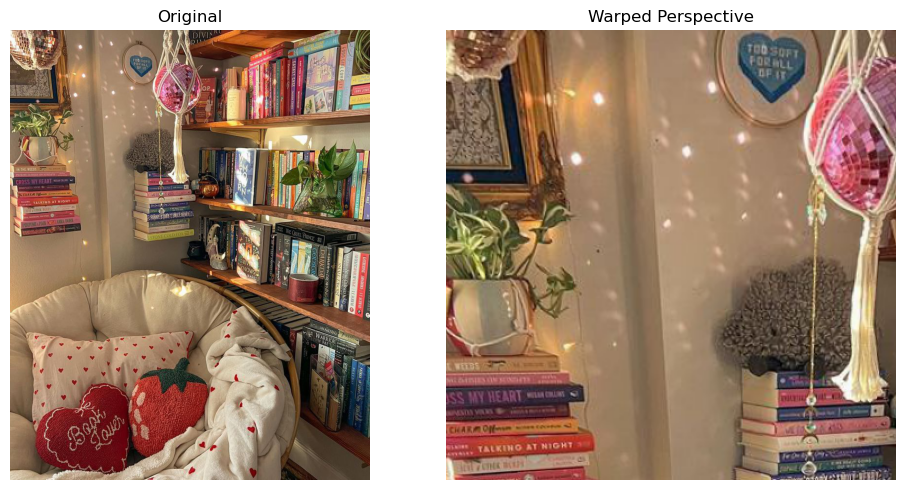

In [16]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from skimage.draw import polygon

# --- Load image or create a synthetic one if the file is missing ---
try:
    #img = Image.open('/Users/babu/Downloads/cobra.png')
    img = Image.open('image1.jpg')
    image = np.array(img)  # uint8 array (H, W, C)
except FileNotFoundError:
    image = np.zeros((400, 400, 3), dtype=np.uint8)
    pts = np.array([[50, 50], [350, 50], [380, 380], [20, 380]])
    rr, cc = polygon(pts[:, 1], pts[:, 0], shape=image.shape[:2])
    image[rr, cc] = [0, 255, 0]
    src_pts = pts
else:
    # Adjust these to your real corners if needed
    src_pts = np.array([[50, 50], [350, 50], [380, 380], [20, 380]])

# Destination rectangle (target corners)
dst_pts = np.array([[0, 0], [400, 0], [400, 400], [0, 400]])

# --- Projective transform ---
tform = transform.ProjectiveTransform()
ok = tform.estimate(src_pts, dst_pts)  # estimate(src, dst)
if not ok:
    raise RuntimeError("Failed to estimate projective transform from given points.")

# --- Warp ---
# Keep original intensity range; result will be float in [0,255] -> cast manually
warped = transform.warp(
    image,
    inverse_map=tform.inverse,
    output_shape=(400, 400),
    preserve_range=True,  # keep 0–255 range
    order=1,
    mode='constant',
)

# Convert to uint8 safely (avoid img_as_ubyte since values are 0–255 floats)
warped = np.clip(warped, 0, 255).astype(np.uint8)

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(warped)
axes[1].set_title('Warped Perspective')
axes[1].axis('off')

plt.tight_layout()
plt.show()

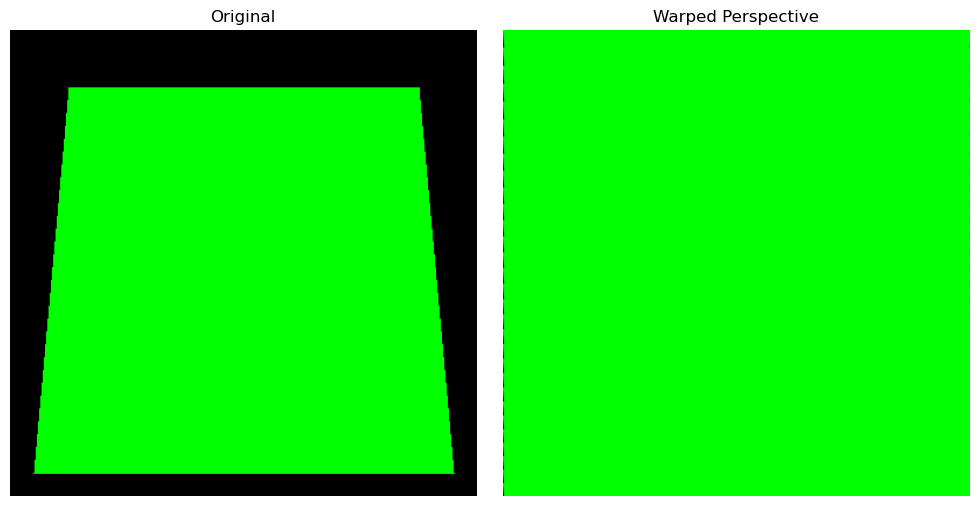

In [17]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from skimage.draw import polygon

# --- Load image or create a synthetic one if the file is missing ---
try:
    #img = Image.open('/Users/babu/Downloads/cobra.png')
    img = Image.open('image1ffffff.jpg')
    image = np.array(img)  # uint8 array (H, W, C)
except FileNotFoundError:
    image = np.zeros((400, 400, 3), dtype=np.uint8)
    pts = np.array([[50, 50], [350, 50], [380, 380], [20, 380]])
    rr, cc = polygon(pts[:, 1], pts[:, 0], shape=image.shape[:2])
    image[rr, cc] = [0, 255, 0]
    src_pts = pts
else:
    # Adjust these to your real corners if needed
    src_pts = np.array([[50, 50], [350, 50], [380, 380], [20, 380]])

# Destination rectangle (target corners)
dst_pts = np.array([[0, 0], [400, 0], [400, 400], [0, 400]])

# --- Projective transform ---
tform = transform.ProjectiveTransform()
ok = tform.estimate(src_pts, dst_pts)  # estimate(src, dst)
if not ok:
    raise RuntimeError("Failed to estimate projective transform from given points.")

# --- Warp ---
# Keep original intensity range; result will be float in [0,255] -> cast manually
warped = transform.warp(
    image,
    inverse_map=tform.inverse,
    output_shape=(400, 400),
    preserve_range=True,  # keep 0–255 range
    order=1,
    mode='constant',
)

# Convert to uint8 safely (avoid img_as_ubyte since values are 0–255 floats)
warped = np.clip(warped, 0, 255).astype(np.uint8)

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(warped)
axes[1].set_title('Warped Perspective')
axes[1].axis('off')

plt.tight_layout()
plt.show()